# DICE Holistic Results

In [107]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../..'))

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection
from sklearn import manifold
import joblib
from scripts import fit_kde
import json

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
RECOURSE_METHOD = 'dice'
RESULTS_DIR = '../../experiment_results/dice/dice_holistic'

# Preliminaries -- load everything

In [4]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split="train")
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']  # columns which are convenient to drop from the path_df

with open(os.path.join(RESULTS_DIR, 'config.json')) as f:
    config_json = json.load(f)

EVAL_SPLIT = config_json['split']

EVAL_DATASET, _ = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split=EVAL_SPLIT)

config_df = pd.read_csv(os.path.join(RESULTS_DIR, 'experiment_config_df.csv'))
path_df = pd.read_csv(os.path.join(RESULTS_DIR, f'{RECOURSE_METHOD}_paths_df.csv'))
config_df

,batch_id,run_id,run_seed,confidence_cutoff,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds
0,402,402,7527,0.7,50,NaN,3,10084,NaN,1.195662
1,688,688,7527,0.7,50,NaN,3,21148,NaN,1.087155
2,352,352,7527,0.7,50,NaN,3,27716,NaN,1.081702
3,831,831,7527,0.7,50,NaN,3,13501,NaN,1.078059
4,225,225,7527,0.7,50,NaN,3,14811,NaN,1.073128
...,...,...,...,...,...,...,...,...,...,...
1133,503,503,7527,0.7,50,NaN,3,13027,NaN,1.016606
1134,386,386,7527,0.7,50,NaN,3,12533,NaN,1.019117
1135,767,767,7527,0.7,50,NaN,3,16635,NaN,1.019278
1136,260,260,7527,0.7,50,NaN,3,28861,NaN,1.020853


## Load or Fit a KDE

In [5]:
KDE_DIRECTORY = '../../saved_models/kde/credit_card_default_kde.joblib'

if os.path.exists(KDE_DIRECTORY):
    KDE = joblib.load(KDE_DIRECTORY)
else:
    KDE = fit_kde.fit_kde('credit_card_default', KDE_DIRECTORY)

# Analyze the results

In [7]:
SPARSITY_EPSILON = 1e-5

def get_poi_cfes(path_df: pd.DataFrame):
    """Isolate the POIs (Points of Interest) and CFEs (Counterfactual Examples) from the full path results.
    
    POIs and CFEs are listed in the order they originally appear in. There is one POI and one CFE
    for every path that appears in the DataFrame."""
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes

def get_sparsity(path: pd.DataFrame):
    """Returns the maximum number of features changed in any single iteration
    along the path."""
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length(path: pd.DataFrame):
    """Returns the sum of euclidean distances along the path."""
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance(path: pd.DataFrame):
    """Returns the euclidean distance between the first and last points in the path."""
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])


def analyze_paths(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    """Returns a DataFrame containing per-path results.
    
    Each row corresponds to a specific path. Each column is a result metric.
    
    Args:
        paths: The path_df DataFrame to analyze.
        poi_kdes: The KDE scores for the POIs.
        cfe_kdes: The KDE scores for the CFEs.
        config_df: The experiment_config_df for the experiment."""
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length',
               'iteration_count', 'poi_density', 'cfe_density', 
               'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)

pois, cfes = get_poi_cfes(path_df)
poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

results = analyze_paths(path_df, poi_kdes, cfe_kdes, cfe_probs, config_df)
results = results.merge(config_df, how='left', on='run_id').drop(
    columns=['max_iterations', 'noise_ratio',
             'rescale_ratio', 'run_seed'])  # uninteresting columns
results

/tmp/ipykernel_1156/2276747017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
0,402.0,0.0,1.0,56.478818,56.478818,2.0,0.378108,-16228.014838,2.0,402,0.7,3,10084,1.195662
1,402.0,1.0,1.0,17.642628,17.642628,2.0,0.378108,-386.280826,2.0,402,0.7,3,10084,1.195662
2,402.0,2.0,1.0,39.842674,39.842674,2.0,0.378108,-1936.677347,2.0,402,0.7,3,10084,1.195662
3,688.0,0.0,1.0,63.502633,63.502633,2.0,2.416545,-6082.074205,2.0,688,0.7,3,21148,1.087155
4,688.0,1.0,1.0,39.301447,39.301447,2.0,2.416545,-2118.546466,2.0,688,0.7,3,21148,1.087155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,260.0,1.0,1.0,17.306896,17.306896,2.0,1.738925,-26.973277,2.0,260,0.7,3,28861,1.020853
3410,260.0,2.0,1.0,59.581803,59.581803,2.0,1.738925,-4471.161461,1.0,260,0.7,3,28861,1.020853
3411,751.0,0.0,1.0,47.676478,47.676478,2.0,-3.018856,-10552.997066,2.0,751,0.7,3,12206,1.019311
3412,751.0,1.0,1.0,13.712967,13.712967,2.0,-3.018856,-35.961617,1.0,751,0.7,3,12206,1.019311


# Success

StEP always succeeds

In [8]:
DROP_METRICS = ['actual_sparsity', 'run_id', 'batch_id', 'confidence_cutoff', 'num_paths', 'elapsed_recourse_seconds']

results.groupby('success').count()

,run_id,path_id,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
success,,,,,,,,,,,,,
1.0,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414


# Iteration count

DiCE is a counterfactual method, so it succeeds after one iteration.

In [10]:
results.groupby('iteration_count').count()

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
iteration_count,,,,,,,,,,,,,
2.0,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414


# Proximity

QUESTION: Why do some points have high proximity?

<AxesSubplot: xlabel='proximity', ylabel='Count'>

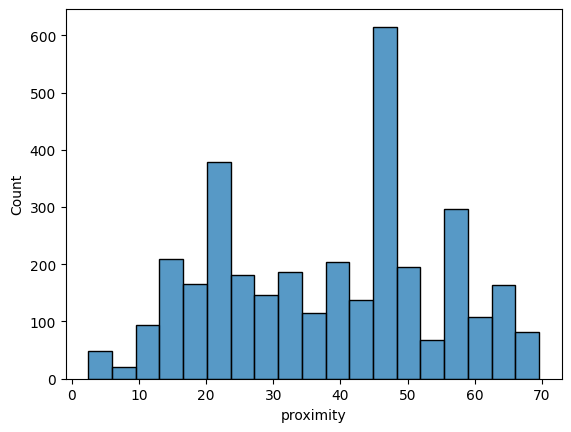

In [11]:
sns.histplot(results, x='proximity')

What about the minimum-path proximity? How does this look?

<AxesSubplot: xlabel='proximity', ylabel='Count'>

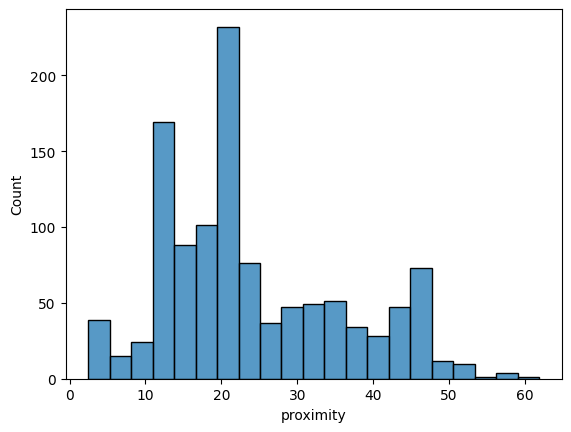

In [98]:
min_prox_results = results.sort_values(['run_id', 'proximity']).iloc[range(0, 3414, 3)]
sns.histplot(min_prox_results, x='proximity')

In [136]:
run_id = min_prox_results[min_prox_results.proximity > 60].run_id.iloc[0]

config_df[config_df.run_id == run_id]

,batch_id,run_id,run_seed,confidence_cutoff,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds
302,511,511,7527,0.7,50,NaN,3,5125,NaN,1.152144


In [137]:
min_prox_results[min_prox_results.proximity > 60]

,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_paths,poi_index,elapsed_recourse_seconds
908,511.0,2.0,1.0,61.857773,61.857773,2.0,-10.056721,-5321.559612,1.0,511,0.7,3,5125,1.152144


In [106]:
path_df[(path_df.run_id == run_id)].iloc[1] - EVAL_DATASET.loc[5125]

AGE          0.000000e+00
BILL_AMT1    7.275958e-12
BILL_AMT2    0.000000e+00
BILL_AMT3    0.000000e+00
BILL_AMT4    0.000000e+00
BILL_AMT5    0.000000e+00
BILL_AMT6    0.000000e+00
LIMIT_BAL    4.863790e+05
PAY_1        0.000000e+00
PAY_2        0.000000e+00
PAY_3        0.000000e+00
PAY_4        0.000000e+00
PAY_5        2.775558e-17
PAY_6        0.000000e+00
PAY_AMT1     0.000000e+00
PAY_AMT2     1.618984e+06
PAY_AMT3     9.094947e-13
PAY_AMT4     0.000000e+00
PAY_AMT5     0.000000e+00
PAY_AMT6     0.000000e+00
Y                     NaN
batch_id              NaN
path_id               NaN
run_id                NaN
step_id               NaN
dtype: float64

In [104]:
EVAL_DATASET.loc[5125]

LIMIT_BAL    150000
AGE              40
PAY_1             1
PAY_2             0
PAY_3             0
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1       -15
BILL_AMT2     17671
BILL_AMT3     14517
BILL_AMT4      1870
BILL_AMT5      3495
BILL_AMT6         0
PAY_AMT1      17686
PAY_AMT2      14517
PAY_AMT3          0
PAY_AMT4       3495
PAY_AMT5          0
PAY_AMT6      21754
Y                 0
Name: 5125, dtype: int64

## What influences whether a point will have high or low proximity?

/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


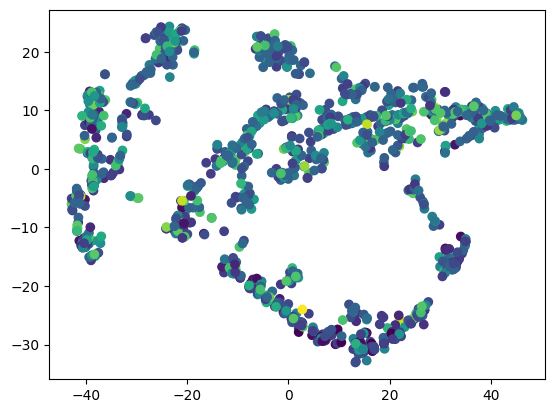

In [133]:
pois = EVAL_DATASET.loc[min_prox_results.poi_index]
tsne = manifold.TSNE(learning_rate='auto')
tsne_data = tsne.fit_transform(pois.drop(columns='Y'))
plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1], c=min_prox_results.proximity)

# Some observations

Question: what can we intuit about how DICE creates recourse? Are there particular columns it likes to adjust?


Observations:
* PAY_AMT1 and PAY_AMT2 have highest average difference
* DICE never recommends paying less
* The columns which appear most frequently in the top 3 changed columns are BILL_AMT6, PAY_AMT1, PAY_AMT2, and PAY_AMT3
    - the methodology doesn't actually support this claim, but it's close enough. We can do more analysis if we want to state this in the paper.

In [77]:
differences = ADAPTER.transform(cfes).drop(columns=['step_id', 'path_id', 'run_id', 'batch_id']).reset_index(drop=True) - ADAPTER.transform(pois.drop(columns = ['step_id', 'path_id', 'run_id', 'batch_id'])).reset_index(drop=True)

(differences.abs()).mean()

LIMIT_BAL     0.134395
AGE           0.041656
PAY_1         0.134725
PAY_2         0.091413
PAY_3         0.150424
PAY_4         0.086862
PAY_5         0.018673
PAY_6         0.080418
BILL_AMT1     0.097788
BILL_AMT2     0.118401
BILL_AMT3     0.510092
BILL_AMT4     0.170368
BILL_AMT5     0.324527
BILL_AMT6     0.110602
PAY_AMT1     16.426669
PAY_AMT2     19.756605
PAY_AMT3      1.795424
PAY_AMT4      0.958290
PAY_AMT5      0.440950
PAY_AMT6      0.278408
dtype: float64

In [56]:
(differences < 0).any()

LIMIT_BAL     True
AGE           True
PAY_1         True
PAY_2         True
PAY_3         True
PAY_4         True
PAY_5         True
PAY_6         True
BILL_AMT1     True
BILL_AMT2     True
BILL_AMT3     True
BILL_AMT4     True
BILL_AMT5     True
BILL_AMT6     True
PAY_AMT1     False
PAY_AMT2     False
PAY_AMT3     False
PAY_AMT4     False
PAY_AMT5     False
PAY_AMT6     False
dtype: bool

In [75]:
df = pd.DataFrame(data = np.sort((-differences.abs().to_numpy()).argpartition(kth=3, axis=1)[:,:3], axis=1), columns=['col1', 'col2', 'col3'])
df['col1'] = differences.columns[df.col1]
df['col2'] = differences.columns[df.col2]
df['col3'] = differences.columns[df.col3]

(-df.groupby(['col1', 'col2', 'col3']).size()).sort_values()[:20]

col1       col2       col3    
BILL_AMT6  PAY_AMT1   PAY_AMT2   -908
           PAY_AMT2   PAY_AMT3   -771
           PAY_AMT1   PAY_AMT3   -111
LIMIT_BAL  PAY_AMT1   PAY_AMT2    -97
PAY_3      BILL_AMT6  PAY_AMT2    -89
BILL_AMT3  BILL_AMT5  PAY_AMT2    -87
BILL_AMT5  BILL_AMT6  PAY_AMT2    -82
BILL_AMT6  PAY_AMT2   PAY_AMT4    -76
           PAY_AMT1   PAY_AMT4    -75
           PAY_AMT2   PAY_AMT5    -74
PAY_1      BILL_AMT6  PAY_AMT2    -70
PAY_4      BILL_AMT6  PAY_AMT1    -68
BILL_AMT4  BILL_AMT6  PAY_AMT1    -68
                      PAY_AMT2    -61
BILL_AMT2  BILL_AMT6  PAY_AMT1    -60
BILL_AMT3  BILL_AMT5  PAY_AMT1    -58
BILL_AMT2  PAY_AMT1   PAY_AMT2    -57
PAY_AMT1   PAY_AMT2   PAY_AMT6    -56
PAY_6      BILL_AMT6  PAY_AMT2    -55
PAY_2      PAY_AMT1   PAY_AMT2    -45
dtype: int64

# Density

<AxesSubplot: xlabel='poi_density', ylabel='Count'>

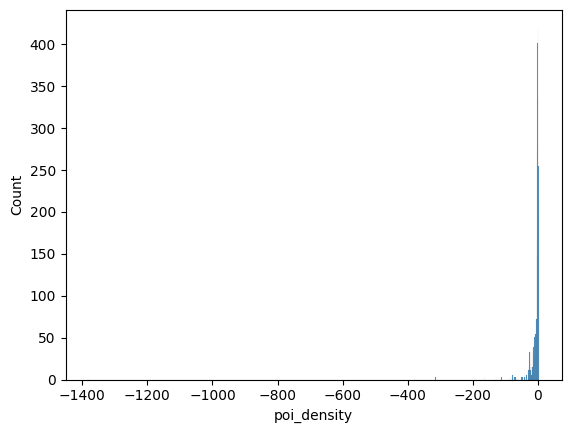

In [19]:
sns.histplot(results, x='poi_density')

<AxesSubplot: xlabel='cfe_density', ylabel='Count'>

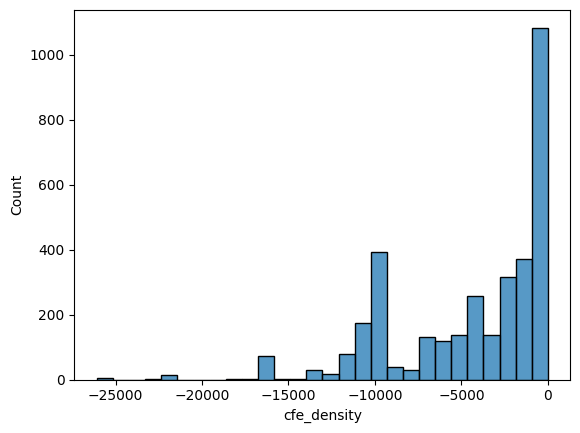

In [20]:
sns.histplot(results, x='cfe_density')

In [21]:
results.groupby('path_id').mean()[['cfe_density', 'poi_density', 'proximity']]

,cfe_density,poi_density,proximity
path_id,,,
0.0,-6040.934023,-7.64285,41.006936
1.0,-2978.134156,-7.64285,33.585507
2.0,-4193.271971,-7.64285,39.884430
